In [1]:
import os;os.chdir('../')
import pylab as pl
import fiona, numpy as np
from pyscissor import scissor
from netCDF4 import Dataset,num2date
import cartopy.crs as ccrs
from shapely.geometry import shape
from datetime import datetime as dt
from cartopy.feature import ShapelyFeature
%config InlineBackend.figure_format = 'svg'

In [2]:
# read shapefile and netcdf file
ncf= Dataset('data/sample_1.nc','r')
sf = fiona.open('zip://data/shape_esri.zip','r') 

In [3]:
lats =ncf.variables['lat'][:]
lons =ncf.variables['lon'][:] # increasing lat (reversed)
temp =ncf.variables['temperature'][:,0,:,:] - 273.15 # K to C conversion
times=num2date(ncf.variables['time'][:],ncf.variables['time'].units,ncf.variables['time'].calendar)[:]
times_py=[dt(x.year,x.month,x.day,x.hour,x.minute) for x in times]

## Calculate mask weight grid for shapefile

In [4]:
record = next(iter(sf))
shapely_shape = shape(record['geometry'])

In [5]:
pys = scissor(shapely_shape,lats,lons)
wg = pys.get_masked_weight()

## Plot weigheted grid


(20.41, 24.61)

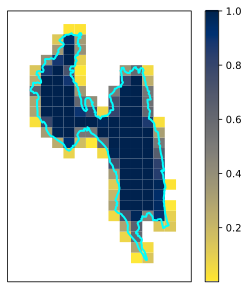

In [6]:
# extent of plot
x0,x1=90.18, 93.03
y0,y1=20.41, 24.61

# cartopy feature
cart_ft = ShapelyFeature([shapely_shape],ccrs.PlateCarree(),facecolor='none',edgecolor='cyan',linewidth=2)

# plot
fig =pl.figure(figsize=(5,5))
ax=pl.axes(projection=ccrs.PlateCarree())
pl.pcolormesh(lons,lats,wg,cmap='cividis_r',shading='nearest')
pl.colorbar()
ax.add_feature(cart_ft)
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)

## Plot masked temperature

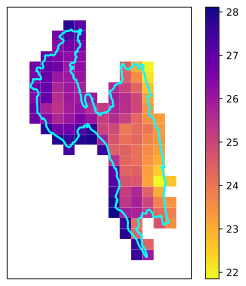

In [7]:
# assign mask 
temp.mask=wg.mask

# plot masked temperature of first time step
fig =pl.figure(figsize=(5,5))
ax=pl.axes(projection=ccrs.PlateCarree())
pl.pcolormesh(lons,lats,temp[-1],cmap='plasma_r')
pl.colorbar()
ax.add_feature(cart_ft)
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)
pl.show()

## Time-Series of average data of masked area 

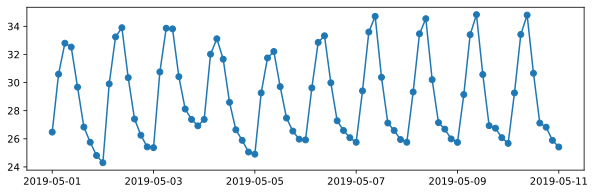

In [8]:
temp_avg = np.zeros(times.shape[0])

for t in range(times.shape[0]):
    temp_avg[t] = temp[t].mean()

# plot
pl.figure(figsize=(10,3))
pl.plot(times_py,temp_avg,'o-')

## Weighted average time series of masked area
Weighted average is useful when calculating rainfall. Here temperature is used for demmonstration purpose

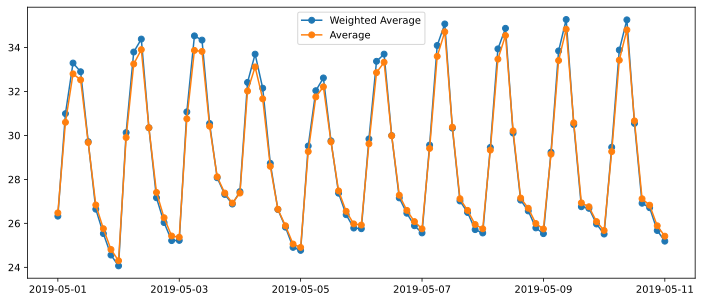

In [9]:
w_temp_avg = np.zeros(times.shape[0])

for t in range(times.shape[0]):
    w_temp_avg[t] = np.average(temp[t],weights=wg)

# plot
pl.figure(figsize=(12,5))
pl.plot(times_py,w_temp_avg,'o-',label='Weighted Average')
pl.plot(times_py,temp_avg,'o-',label='Average')
pl.legend()